On va directement commencer par importer les librairies qui vont nous être utiles et par télécharger les package nltk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import unicodedata
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Styx6/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Styx6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Styx6/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

Création du jeu de données synthétiques, on rappelle que ce jeu de données est très petit et sert uniquement d'exemple. On utilisera des grands Dataset pour des sitautions réelles.

In [4]:
# Création d'un jeu de données synthétique
data = {
    'avis': [
        # Avis positifs
        "Ce produit est absolument génial ! Je le recommande vivement à tous.",
        "Super rapport qualité-prix, livraison rapide et emballage soigné !",
        "J'adore ce produit, il a dépassé toutes mes attentes !!! :)",
        "Le design est superbe et les fonctionnalités sont top. Achat satisfaisant.",
        "Excellent produit, conforme à la description et très facile à utiliser.",
        "Produit de très bonne qualité, je suis ravi de mon achat !",
        "Livraison rapide et produit conforme à mes attentes. Je recommande !",
        "Très bon rapport qualité/prix, je ne regrette pas mon achat.",
        "Fonctionne parfaitement, simple d'utilisation et design élégant.",
        "Service client réactif et à l'écoute. Produit impeccable.",
        "Achat que je ne regrette absolument pas, qualité exceptionnelle.",
        "Produit robuste et fiable, cela fait 6 mois que je l'utilise sans problème.",
        "Je suis bluffé par la qualité de ce produit, c'est un sans-faute !",
        "Un indispensable à ce prix, je le conseille à tous mes amis.",
        "Expérience d'achat parfaite du début à la fin.",
        
        # Avis négatifs
        "Très déçu par la qualité... Ne fonctionne pas comme prévu.",
        "Produit cassé à l'arrivée, service client injoignable. À éviter !",
        "Médiocre, ne vaut pas son prix. J'ai retourné le produit après 2 jours.",
        "N'achetez pas ce produit ! Il s'est cassé après seulement 1 semaine d'utilisation...",
        "Délai de livraison beaucoup trop long, et produit différent des photos. Déception totale.",
        "Qualité médiocre, ne tient pas ses promesses. Je déconseille fortement.",
        "SAV catastrophique, impossible d'obtenir un remboursement malgré un produit défectueux.",
        "Produit bas de gamme vendu à prix d'or. Arnaque totale !",
        "Fragile et peu fiable, déjà en panne après quelques utilisations.",
        "Interface compliquée et bugs fréquents, je regrette cet achat.",
        "Livraison en retard et emballage négligé, produit abîmé.",
        "Performances bien en-dessous de ce qui est annoncé. Très décevant.",
        "Produit incompatible avec mon équipement malgré les indications contraires.",
        "Design cheap et matériaux de mauvaise qualité, ça fait vraiment pas sérieux.",
        "Batterie défaillante, autonomie ridicule comparée à ce qui est annoncé."
    ],
    'sentiment': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # 1 = positif, 0 = négatif
}

df = pd.DataFrame(data)
print(f"Dimensions du dataset: {df.shape}")
df.head()

Dimensions du dataset: (30, 2)


,avis,sentiment
0,Ce produit est absolument génial ! Je le recom...,1
1,"Super rapport qualité-prix, livraison rapide e...",1
2,"J'adore ce produit, il a dépassé toutes mes at...",1
3,Le design est superbe et les fonctionnalités s...,1
4,"Excellent produit, conforme à la description e...",1


Décrivons ensemble le dataset en visualisant la distribution des sentiments

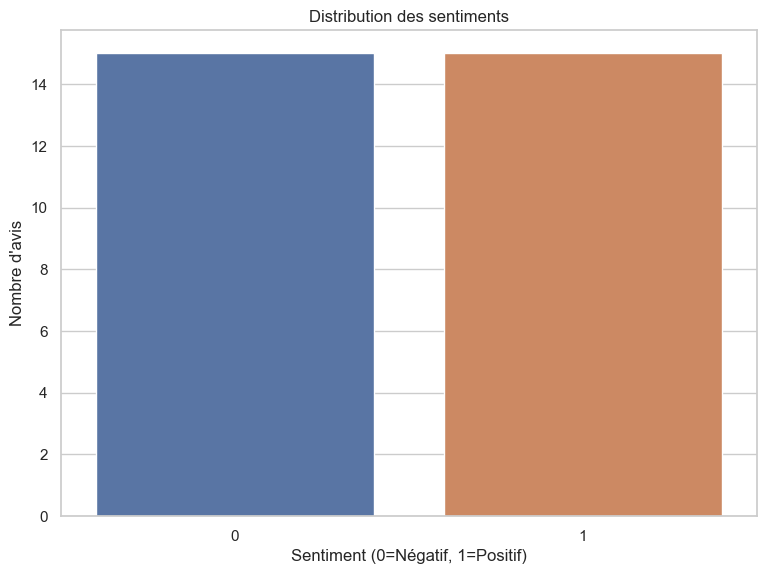

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution des sentiments')
plt.xlabel('Sentiment (0=Négatif, 1=Positif)')
plt.ylabel('Nombre d\'avis')
plt.show()

Maintenant que nous avons exploré notre jeu de données, passons aux étapes de preprocessing. Cette étape consiste à 
- Convertir le texte en minuscules
- Supprimer les caractères spéciaux, la ponctuation et les chiffres
- Supprimer les espaces multiples

In [6]:
def nettoyer_texte(texte):
    texte = texte.lower()
    texte = ''.join(c for c in unicodedata.normalize('NFD', texte) if unicodedata.category(c) != 'Mn')
    texte = re.sub(f'[{string.punctuation}]', ' ', texte)
    texte = re.sub(r'\d+', '', texte)
    texte = re.sub(r'\s+', ' ', texte).strip()
    return texte


In [7]:
df['texte_nettoye'] = df['avis'].apply(nettoyer_texte)

In [8]:
print("Comparaison avant/après nettoyage:")
for i in range(3):  # Afficher quelques exemples
    print(f"\nTexte original: {df['avis'][i]}")
    print(f"Texte nettoyé: {df['texte_nettoye'][i]}")

Comparaison avant/après nettoyage:

Texte original: Ce produit est absolument génial ! Je le recommande vivement à tous.
Texte nettoyé: ce produit est absolument genial je le recommande vivement a tous

Texte original: Super rapport qualité-prix, livraison rapide et emballage soigné !
Texte nettoyé: super rapport qualite prix livraison rapide et emballage soigne

Texte original: J'adore ce produit, il a dépassé toutes mes attentes !!! :)
Texte nettoyé: j adore ce produit il a depasse toutes mes attentes


On a bien supprimé toute la ponctuation et les caractères spéciaux. Il ne reste que des caractères et c'est exactement ce que nous voulions

Abordons maintenant la Tokenisation. La tokenisation consiste à découper le texte en unités élémentaires ( mots ou sous-mots ). 




In [9]:
def tokeniser(texte):
    tokenizer = TreebankWordTokenizer()
    return tokenizer.tokenize(texte)


In [10]:
df['tokens'] = df['texte_nettoye'].apply(tokeniser)

In [11]:
print("Exemples de tokenisation:")
for i in range(3):  # Afficher quelques exemples
    print(f"\nTexte nettoyé: {df['texte_nettoye'][i]}")
    print(f"Tokens: {df['tokens'][i]}")

Exemples de tokenisation:

Texte nettoyé: ce produit est absolument genial je le recommande vivement a tous
Tokens: ['ce', 'produit', 'est', 'absolument', 'genial', 'je', 'le', 'recommande', 'vivement', 'a', 'tous']

Texte nettoyé: super rapport qualite prix livraison rapide et emballage soigne
Tokens: ['super', 'rapport', 'qualite', 'prix', 'livraison', 'rapide', 'et', 'emballage', 'soigne']

Texte nettoyé: j adore ce produit il a depasse toutes mes attentes
Tokens: ['j', 'adore', 'ce', 'produit', 'il', 'a', 'depasse', 'toutes', 'mes', 'attentes']


On va maintenant supprimer les stopwords. Les stopwords sont des mots très fréquents (comme "le", "la", "et", etc.) qui n'apportent généralement pas de valeur sémantique significative.

In [12]:
stop_words = set(stopwords.words('french'))

In [13]:
def supprimer_stopwords(tokens):
    return [mot for mot in tokens if mot not in stop_words]

In [14]:
df['tokens_sans_stopwords'] = df['tokens'].apply(supprimer_stopwords)

In [15]:
print("Exemples de suppression des stopwords:")
for i in range(3):
    print(f"\nTokens originaux: {df['tokens'][i]}")
    print(f"Tokens sans stopwords: {df['tokens_sans_stopwords'][i]}")

Exemples de suppression des stopwords:

Tokens originaux: ['ce', 'produit', 'est', 'absolument', 'genial', 'je', 'le', 'recommande', 'vivement', 'a', 'tous']
Tokens sans stopwords: ['produit', 'absolument', 'genial', 'recommande', 'vivement', 'a', 'tous']

Tokens originaux: ['super', 'rapport', 'qualite', 'prix', 'livraison', 'rapide', 'et', 'emballage', 'soigne']
Tokens sans stopwords: ['super', 'rapport', 'qualite', 'prix', 'livraison', 'rapide', 'emballage', 'soigne']

Tokens originaux: ['j', 'adore', 'ce', 'produit', 'il', 'a', 'depasse', 'toutes', 'mes', 'attentes']
Tokens sans stopwords: ['adore', 'produit', 'a', 'depasse', 'toutes', 'attentes']


Passons maintenant à la lemmatisation et le stemming qui sont des techniques pour réduire les mots à leur forme canonique ou racine.

In [16]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [17]:
def lemmatiser(tokens):
    return [lemmatizer.lemmatize(mot) for mot in tokens]

def stemmer_tokens(tokens):
    return [stemmer.stem(mot) for mot in tokens]


Le stemming tronque les mots en supprimant les suffixes pour obtenir une racine approximative (ex: "manger", "mangeais" devient "mang"). 

La lemmatisation utilise un dictionnaire pour ramener un mot à sa forme lexicale correcte (ex: "manger", "mangeais" devient "manger"). Elle est plus précise mais plus lente car elle prend en compte le contexte grammatical.

La lemmatisation repose sur la modélisation de la langue sous forme de graphes lexicaux et utilise une fonction de mappage basée sur des relations entre mots pour retrouver leur forme canonique. Elle s'appuie sur des techniques comme le POS tagging (étiquetage grammatical) avec des modèles de Markov cachés (HMM) ou des modèles probabilistes bayésiens, permettant d’inférer la bonne lemmatisation en fonction du contexte.

Le stemming quant à lui applique des règles heuristiques, et des transformations de chaînes pour tronquer les mots en supprimant leurs suffixes, sans toujours respecter la grammaire. Il utilise des expressions régulières, des tables de transition de suffixes et des algorithmes comme Porter ou Snowball.



In [18]:
df['tokens_lemmatises'] = df['tokens_sans_stopwords'].apply(lemmatiser)
df['tokens_stemmes'] = df['tokens_sans_stopwords'].apply(stemmer_tokens)

In [19]:
print("Comparaison lemmatisation vs stemming:")
for i in range(3):
    print(f"\nTokens sans stopwords: {df['tokens_sans_stopwords'][i]}")
    print(f"Tokens lemmatisés: {df['tokens_lemmatises'][i]}")
    print(f"Tokens stemmés: {df['tokens_stemmes'][i]}")

Comparaison lemmatisation vs stemming:

Tokens sans stopwords: ['produit', 'absolument', 'genial', 'recommande', 'vivement', 'a', 'tous']
Tokens lemmatisés: ['produit', 'absolument', 'genial', 'recommande', 'vivement', 'a', 'tous']
Tokens stemmés: ['produit', 'absolu', 'genial', 'recommand', 'vivement', 'a', 'tou']

Tokens sans stopwords: ['super', 'rapport', 'qualite', 'prix', 'livraison', 'rapide', 'emballage', 'soigne']
Tokens lemmatisés: ['super', 'rapport', 'qualite', 'prix', 'livraison', 'rapide', 'emballage', 'soigne']
Tokens stemmés: ['super', 'rapport', 'qualit', 'prix', 'livraison', 'rapid', 'emballag', 'soign']

Tokens sans stopwords: ['adore', 'produit', 'a', 'depasse', 'toutes', 'attentes']
Tokens lemmatisés: ['adore', 'produit', 'a', 'depasse', 'toutes', 'attentes']
Tokens stemmés: ['ador', 'produit', 'a', 'depass', 'tout', 'attent']


On va maintenant reconstituer les textes à partir des tokens traités

In [20]:
df['texte_lemmatise'] = df['tokens_lemmatises'].apply(lambda x: ' '.join(x))
df['texte_stemme'] = df['tokens_stemmes'].apply(lambda x: ' '.join(x))

In [21]:
print("Textes reconstitués après traitement complet:")
for i in range(3):
    print(f"\nTexte original: {df['avis'][i]}")
    print(f"Texte après lemmatisation: {df['texte_lemmatise'][i]}")
    print(f"Texte après stemming: {df['texte_stemme'][i]}")

Textes reconstitués après traitement complet:

Texte original: Ce produit est absolument génial ! Je le recommande vivement à tous.
Texte après lemmatisation: produit absolument genial recommande vivement a tous
Texte après stemming: produit absolu genial recommand vivement a tou

Texte original: Super rapport qualité-prix, livraison rapide et emballage soigné !
Texte après lemmatisation: super rapport qualite prix livraison rapide emballage soigne
Texte après stemming: super rapport qualit prix livraison rapid emballag soign

Texte original: J'adore ce produit, il a dépassé toutes mes attentes !!! :)
Texte après lemmatisation: adore produit a depasse toutes attentes
Texte après stemming: ador produit a depass tout attent


Maintenant que nous avons prétraité nos textes, nous allons les transformer en représentations numériques pour pouvoir les utiliser avec des algorithmes d'apprentissage automatique.

On va commencer par utiliser la méthode BOW ( Bag of Words). BOW transforme chaque phrase de mon dataset en un vecteur numérique basé sur la présence et la fréquence d'apparition mots dans l'ensemble de mon dataset. Chaque phrase est représentée par un vecteur, où chaque dimension indique si un mot est présent (ou combien de fois il apparaît). Ainsi, avec 10 avis clients, on obtiendra 10 vecteurs, chacun ayant une dimension correspondant au nombre total de mots uniques apapraissant dans le dataset.

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['texte_lemmatise'], df['sentiment'], test_size=0.3, random_state=42)


In [24]:
bow_vectorizer = CountVectorizer()
X_bow_lemma = bow_vectorizer.fit_transform(df['texte_lemmatise'])
X_bow_stem = bow_vectorizer.fit_transform(df['texte_stemme'])


In [25]:
print(f"Dimensions des matrices BOW:")
print(f"Lemmatisation: {X_bow_lemma.shape}")
print(f"Stemming: {X_bow_stem.shape}")


# Affichage du vocabulaire du dataset
print(f"\nVocabulaire BOW - {len(bow_vectorizer.vocabulary_)} mots uniques :")
print(list(bow_vectorizer.vocabulary_.keys()))



Dimensions des matrices BOW:
Lemmatisation: (30, 134)
Stemming: (30, 131)

Vocabulaire BOW - 131 mots uniques :
['produit', 'absolu', 'genial', 'recommand', 'vivement', 'tou', 'super', 'rapport', 'qualit', 'prix', 'livraison', 'rapid', 'emballag', 'soign', 'ador', 'depass', 'tout', 'attent', 'design', 'superb', 'fonctionnalit', 'top', 'achat', 'satisfais', 'excel', 'conform', 'descript', 'tre', 'facil', 'utilis', 'bonn', 'ravi', 'bon', 'regrett', 'fonctionn', 'parfait', 'simpl', 'eleg', 'servic', 'client', 'reactif', 'ecout', 'impecc', 'exceptionnel', 'robust', 'fiabl', 'cela', 'fait', 'moi', 'san', 'problem', 'bluff', 'faut', 'indispens', 'conseil', 'ami', 'experi', 'debut', 'fin', 'decu', 'comm', 'prevu', 'cass', 'arrive', 'injoign', 'evit', 'mediocr', 'vaut', 'retourn', 'apr', 'jour', 'achetez', 'seulement', 'semain', 'delai', 'beaucoup', 'trop', 'long', 'differ', 'photo', 'decept', 'total', 'tient', 'promess', 'deconseil', 'fortement', 'sav', 'catastrophiqu', 'imposs', 'obtenir', '

Autre méthode de vectorisation : la méthode TF-IDF (Term Frequency-Inverse Document Frequency) . Celle-ci pondère les fréquences des mots en fonction de leur rareté dans le dataset.

In [26]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf_lemma = tfidf_vectorizer.fit_transform(df['texte_lemmatise'])
X_tfidf_stem = tfidf_vectorizer.fit_transform(df['texte_stemme'])

In [27]:
print(f"Dimensions des matrices TF-IDF:")
print(f"Lemmatisation: {X_tfidf_lemma.shape}")
print(f"Stemming: {X_tfidf_stem.shape}")

Dimensions des matrices TF-IDF:
Lemmatisation: (30, 134)
Stemming: (30, 131)


On constate que le résultat est identique même si la méthode de vectorisation est différente

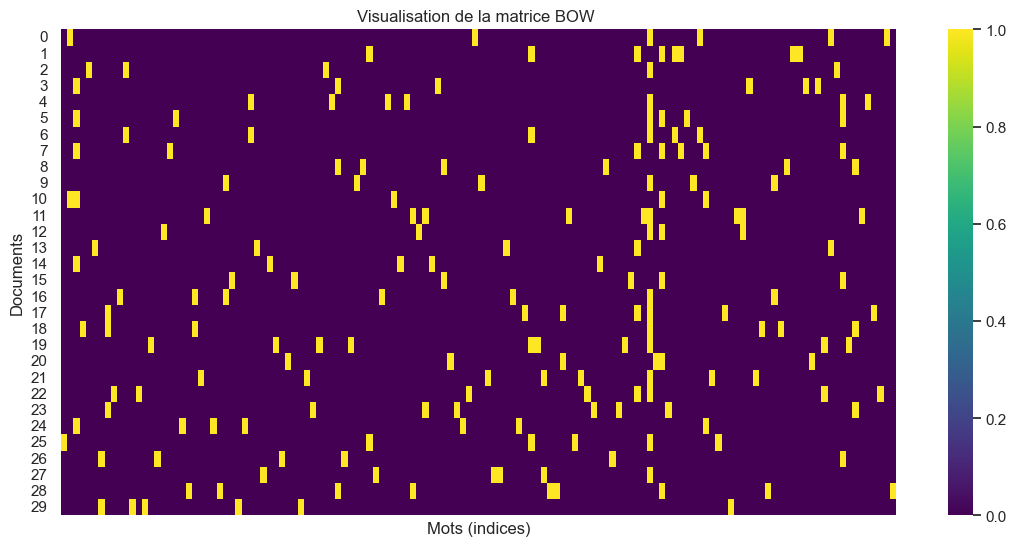

In [28]:
bow_array = X_bow_lemma.toarray()
tfidf_array = X_tfidf_lemma.toarray()

# Visualisation de la matrice BoW
plt.figure(figsize=(12, 6))
sns.heatmap(bow_array, cmap='viridis', annot=False, xticklabels=False)
plt.title('Visualisation de la matrice BOW ')
plt.xlabel('Mots (indices)')
plt.ylabel('Documents')
plt.show()

Ce graphique représente une heatmap de la matrice BOW de notre dataset

    Les colonnes représentent les mots du vocabulaire global (identifiés par leur indice).
    Les zones jaunes indiquent la présence d’un mot dans un document, tandis que les zones violettes indiquent son absence.

On observe que certains mots sont partagés entre plusieurs documents, mais chaque avis utilise un sous-ensemble réduit du vocabulaire total. Cela illustre bien le fonctionnement de BOW, qui ne capture ni le sens ni l’ordre des mots, mais uniquement leur présence ou absence dans chaque document.

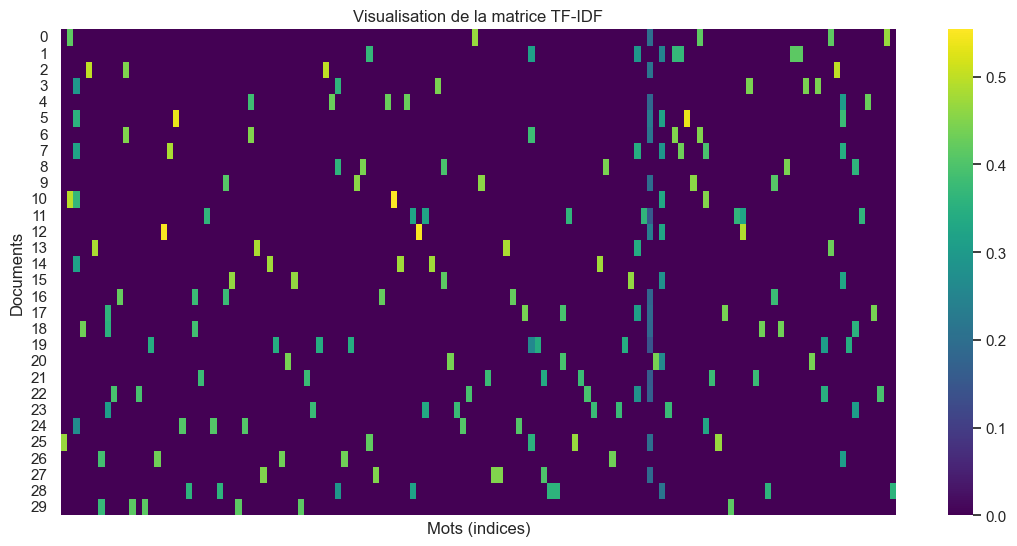

In [29]:
plt.figure(figsize=(12, 6))
sns.heatmap(tfidf_array, cmap='viridis', annot=False, xticklabels=False)
plt.title('Visualisation de la matrice TF-IDF')
plt.xlabel('Mots (indices)')
plt.ylabel('Documents')
plt.show()


Contrairement à la matrice BOW, où seule la présence et l’absence des mots étaient prise en compte, ici, les valeurs sont pondérées en fonction de la fréquence du mot dans le document et de sa rareté dans l’ensemble du dataset.

Interprétation :

    Les zones en jaune indiquent des mots avec un score TF-IDF élevé, donc considérés comme plus représentatifs du document.
    Les zones en vert/bleu indiquent des mots ayant une importance plus faible, car soit très fréquents dans tous les documents (mots courants), soit peu significatifs.
    La sparsité est toujours présente (majorité de violet), mais l’information est mieux équilibrée que dans BOW, où tous les mots avaient le même poids.

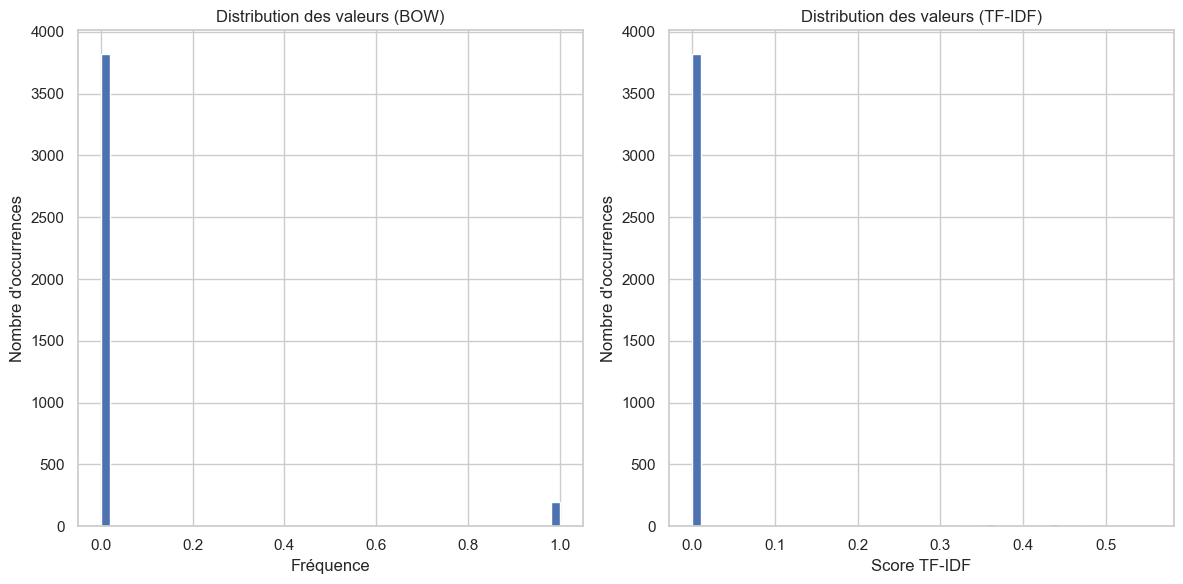

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(bow_array.flatten(), bins=50)
plt.title('Distribution des valeurs (BOW)')
plt.xlabel('Fréquence')
plt.ylabel('Nombre d\'occurrences')

plt.subplot(1, 2, 2)
plt.hist(tfidf_array.flatten(), bins=50)
plt.title('Distribution des valeurs (TF-IDF)')
plt.xlabel('Score TF-IDF')
plt.ylabel('Nombre d\'occurrences')
plt.tight_layout()
plt.show()

On observe ici une comparaison de la distribution des valeurs pour BOW et pour TF-IDF. 
Les deux distributions sont très creuses (beaucoup de valeurs à 0), ce qui est normal en NLP.
BOW est purement binaire (0 ou 1), tandis que TF-IDF attribue des scores plus variés, mettant mieux en valeur les mots importants.
TF-IDF semble mieux adapté à la classification et l’analyse, car il réduit l’influence des mots trop fréquents.

Maintenant que nous avons vectorisé nos textes, essayons d'entraîner des modèles de classification pour prédire le sentiment lié à chaque avis.

In [31]:
y = df['sentiment'].values

In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [33]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow_lemma, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tfidf, X_test_tfidf, _, _ = train_test_split(
    X_tfidf_lemma, y, test_size=0.2, random_state=42, stratify=y
)

On va commencer par utiliser un modèle Naïve-Bayes avec BOW

In [34]:
nb_bow = MultinomialNB(alpha=0.1)
nb_bow.fit(X_train_bow, y_train)
y_pred_bow = nb_bow.predict(X_test_bow)

In [35]:
cv_scores_bow = cross_val_score(MultinomialNB(alpha=0.1), X_bow_lemma, y, cv=5, scoring='accuracy')

Puis Naïve-Bayes avec TF-IDF


In [36]:
nb_tfidf = MultinomialNB(alpha=0.1)
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

In [37]:
cv_scores_tfidf = cross_val_score(MultinomialNB(alpha=0.1), X_tfidf_lemma, y, cv=5, scoring='accuracy')


In [38]:
import warnings
warnings.filterwarnings('ignore')

print("Résultats avec Naive Bayes - BoW:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bow):.4f}")
print(f"Accuracy en validation croisée: {cv_scores_bow.mean():.4f} ± {cv_scores_bow.std():.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_bow))

print("\nRésultats avec Naive Bayes - TF-IDF:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf):.4f}")
print(f"Accuracy en validation croisée: {cv_scores_tfidf.mean():.4f} ± {cv_scores_tfidf.std():.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_tfidf))




Résultats avec Naive Bayes - BoW:
Accuracy: 0.6667
Accuracy en validation croisée: 0.7333 ± 0.2261

Rapport de classification:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6


Résultats avec Naive Bayes - TF-IDF:
Accuracy: 0.6667
Accuracy en validation croisée: 0.7333 ± 0.2261

Rapport de classification:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6





On obtient des résultats identiques ! C'est une coïncidence, mais pourquoi ?

D'abord une ùême division train/test (avec random_state=42 et stratify=y), un même seuil de décision (0.5) pour passer des probabilités aux classes et également la nature très polarisée du texte (mots très significatifs communs aux deux représentations)

En résumé, les deux modèles calculent des probabilités différentes, mais ces différences ne franchissent pas le seuil de décision (0.5) dans des directions opposées. 
C'est rare mais statistiquement possible, surtout avec un petit jeu de test et des exemples très polarisés.

Cette coïncidence illustre bien comment des représentations numériques différentes peuvent capturer la même information essentielle pour un problème de classification binaire simple.

Observons ensemble les matrices de confusions

Text(632.7045454545455, 0.5, 'Réalité')

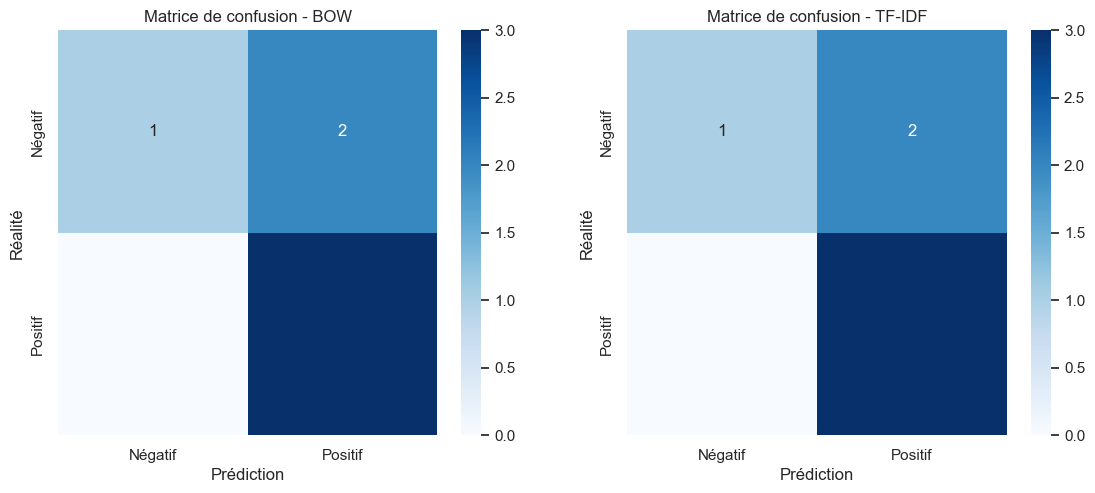

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif'], 
            yticklabels=['Négatif', 'Positif'])
plt.title('Matrice de confusion - BOW')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')

plt.subplot(1, 2, 2)
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif'], 
            yticklabels=['Négatif', 'Positif'])
plt.title('Matrice de confusion - TF-IDF')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')

In [46]:
# Vérifier que les vecteurs sont réellement différents
print("Un élément BOW:", X_bow_lemma[0].toarray()[0][:5])
print("Un élément TF-IDF:", X_tfidf_lemma[0].toarray()[0][:5])

# Vérifier que les prédictions sont calculées séparément
print("Prédictions BOW:", y_pred_bow)
print("Prédictions TF-IDF:", y_pred_tfidf)
print("Identiques?", np.array_equal(y_pred_bow, y_pred_tfidf))

Un élément BOW: [0 1 0 0 0]
Un élément TF-IDF: [0.         0.41716825 0.         0.         0.        ]
Prédictions BOW: [1 1 1 0 1 1]
Prédictions TF-IDF: [1 1 1 0 1 1]
Identiques? True


In [47]:
print("Probabilités BOW:", nb_bow.predict_proba(X_test_bow))
print("Probabilités TF-IDF:", nb_tfidf.predict_proba(X_test_tfidf))

Probabilités BOW: [[0.01061797 0.98938203]
 [0.21941214 0.78058786]
 [0.16486139 0.83513861]
 [0.98648839 0.01351161]
 [0.03505509 0.96494491]
 [0.26220582 0.73779418]]
Probabilités TF-IDF: [[0.19322425 0.80677575]
 [0.44704951 0.55295049]
 [0.38597741 0.61402259]
 [0.74403864 0.25596136]
 [0.27574324 0.72425676]
 [0.4488193  0.5511807 ]]


Terminons avec une analyse des mots les plus importants

In [42]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = nb_tfidf.feature_log_prob_


In [43]:
n_top_words = 10
indices_negatifs = np.argsort(coefficients[0])[-n_top_words:]
indices_positifs = np.argsort(coefficients[1])[-n_top_words:]


In [44]:
print("Mots les plus associés aux avis négatifs:")
for idx in indices_negatifs:
    print(f"- {feature_names[idx]}")

print("\nMots les plus associés aux avis positifs:")
for idx in indices_positifs:
    print(f"- {feature_names[idx]}")

Mots les plus associés aux avis négatifs:
- abim
- problem
- livraison
- trop
- tou
- apr
- quelqu
- annonc
- mediocr
- promess

Mots les plus associés aux avis positifs:
- design
- satisfais
- rapport
- conform
- tout
- regrett
- absolu
- achat
- quelqu
- promess


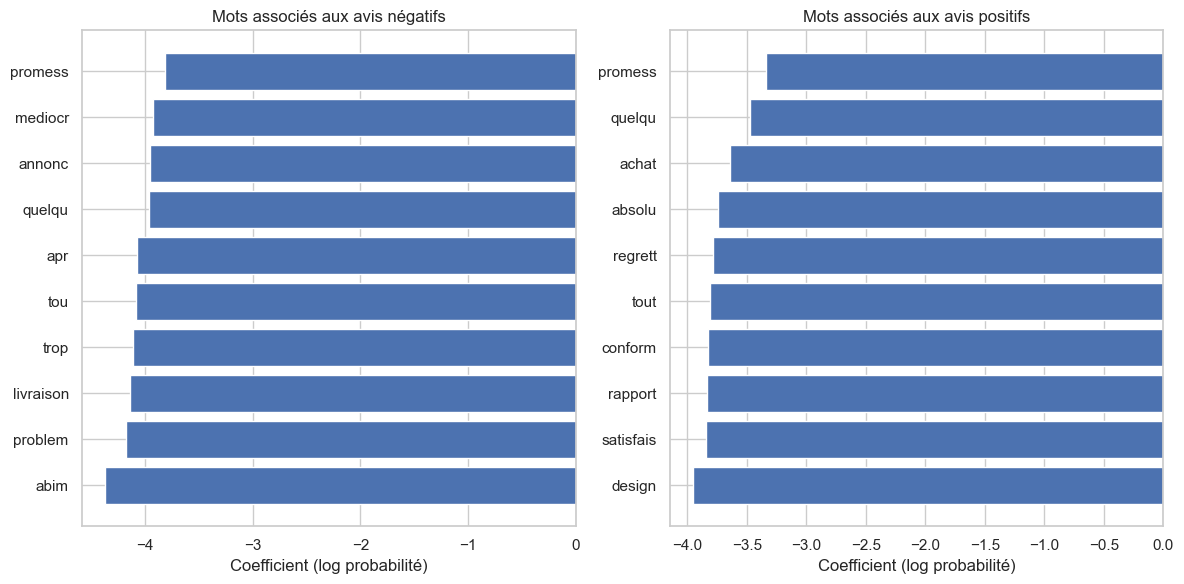

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh([feature_names[idx] for idx in indices_negatifs], 
         [coefficients[0][idx] for idx in indices_negatifs])
plt.title('Mots associés aux avis négatifs')
plt.xlabel('Coefficient (log probabilité)')

# Mots positifs
plt.subplot(1, 2, 2)
plt.barh([feature_names[idx] for idx in indices_positifs], 
         [coefficients[1][idx] for idx in indices_positifs])
plt.title('Mots associés aux avis positifs')
plt.xlabel('Coefficient (log probabilité)')

plt.tight_layout()
plt.show()